# CAFEPP (utilising cafepp.py)

***

## This example will produce a set of monthly SST files across the V1 assimilation run (interpolated onto a 1x1 latxlon grid), and upon success, generate an average over the nino3.4 region and plot the time-series.

***

# Various settings required:

## BATCH determines whether it will be sent to the queue via qsub command or run interactively.

## CLEAN determines whether the run directory will be emptied prior to processing.

In [1]:
print('BEGIN')

from __future__ import print_function #this is to allow print(,file=xxx) feature

import datetime
import shutil
import os

dvar='tos' #variable to generate as well as further proces and plot.

BATCH=True #submit to queue
BATCH=False #run interactively but in a batch temporary area.

CLEAN=False #don't remove rundir, just use it.
CLEAN=True #remove rundir and recreate it.

if(BATCH):
  print('Submitting to queue.')

if(CLEAN):
  print('Removing run directory and reestablish it.')

cmipdir='/short/v14/mac599' #this might be different to predir for other users.
predir='/short/v14/mac599' #this is directory area for temporary cafepp files.
topdir=predir+'/'+'cafepp'
script='cafepp_monthly_assimilation.py'

rundir=topdir+'/'+'rundir20171124143249'
rundir=topdir+'/'+'rundir20171128165302'
rundir=topdir+'/'+'rundir'+datetime.datetime.today().strftime('%Y%m%d%H%M%S')
rundir=topdir+'/'+'rundir' #temporary running directory

print('Running in directory '+rundir)
print('Using script '+script)

srcdir='/home/599/mac599/decadal' #location of main cafepp code
prodir=srcdir+'/paper_analysis' #project directory

print('END')

BEGIN
Removing run directory and reestablish it.
Running in directory /short/v14/mac599/cafepp/rundir
Using script cafepp_monthly_assimilation.py
END


# Here we make directories, copy across necessary JSON and python code.

In [2]:
print('BEGIN')

print('copying json files, generating symlinks, cmor tables, queue script, if necessary.')
if(os.path.exists(rundir) and CLEAN):
  shutil.rmtree(rundir)
  os.mkdir(rundir)
  os.mkdir(rundir+'/'+'JsonTemplates') # exist_ok=True only python3
elif(not os.path.exists(rundir)):
  os.mkdir(rundir)
  os.mkdir(rundir+'/'+'JsonTemplates') # exist_ok=True only python3

if(os.path.isdir(cmipdir+'/'+'CMIP6')):
  print('hello')
  os.symlink(cmipdir+'/'+'CMIP6',rundir+'/'+'CMIP6')
else:
  print('there')
  os.mkdir(cmipdir)
os.symlink(prodir+'/'+'TablesTemplates',rundir+'/'+'TablesTemplates')
os.symlink(prodir+'/'+'cmip6-cmor-tables',rundir+'/'+'cmip6-cmor-tables')

if(BATCH): #temporary
  print('Copying and editing '+prodir+'/'+'qjob.csh to '+rundir+'/'+'qjob.csh')
  ifh=open(prodir+'/'+'qjob.csh')
  ofh=open(rundir+'/'+'qjob.csh','w')
  for i,line in enumerate(ifh):
    line=line.replace('CAFEPP_SCRIPT','./'+script+' RUNDIR')
    line=line.replace('RUNDIR',rundir)
    line=line.replace('CONDA_SOURCE','. /short/v14/mac599/anaconda3/etc/profile.d/conda.sh')
    line=line.replace('CONDA_ACTIVATE','conda activate cafepp_27_scipy')
    print(line,file=ofh,end='')
  ifh.close()
  ofh.close()

vector_string=['decadal_diag.py','cafepp.py','app_funcs.py']
for i,file_now in enumerate(vector_string):
  print('Copying '+srcdir+'/'+file_now+' to ',rundir)
  shutil.copyfile(srcdir+'/'+file_now,rundir+'/'+file_now)

vector_string=[script]
for i,file_now in enumerate(vector_string):
  print('Copying '+prodir+'/'+file_now+' to ',rundir)
  shutil.copyfile(prodir+'/'+file_now,rundir+'/'+file_now)
  
vector_string=[]
vector_string.append(script) #may need to do edits?
vector_string.append('cafepp_monthly_assimilation.json')
vector_string.append('cafepp_daily_forecast_experiments.json')
vector_string.append('JsonTemplates'+'/'+'cafepp_csiro-gfdl.json')
vector_string.append('JsonTemplates'+'/'+'cafepp_vars.json')

for i,file_now in enumerate(vector_string):
  print('Copying '+prodir+'/'+file_now+' to ',rundir)
  shutil.copyfile(prodir+'/'+file_now,rundir+'/'+file_now)
  
print('Processing cafepp_monthly_assimilation.json')
ifh=open(prodir+'/'+'cafepp_monthly_assimilation.json')
ofh=open(rundir+'/'+'cafepp_monthly_assimilation.json','w')
for i,line in enumerate(ifh):
  token1=[str(x) for x in line.split(':')]
  token2=(token1[0].replace(' ',''))
  token3=(token2.replace('"',''))
  if(token3=='dvar'):
    line='     "dvar":"'+dvar+'",\n'
  #elif(token3=='grid_label'):
  #  line='     "grid_label":"gr2",\n'
  #elif(token3=='grid'):
  #  line='     "grid":"data regridded via linear interpolation to a 1x1 degree latxlon  (180x360)grid from the native 300x360 latxlon tri-polar grid",\n'
  print(line,file=ofh,end='')
ifh.close()
ofh.close()

#break
print('END')

BEGIN
copying json files, generating symlinks, cmor tables, queue script, if necessary.
hello
Copying /home/599/mac599/decadal/decadal_diag.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/cafepp.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/app_funcs.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_monthly_assimilation.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_monthly_assimilation.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_monthly_assimilation.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_forecast_experiments.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/JsonTemplates/cafepp_csiro-gfdl.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/JsonTemplates/cafepp_

# We establish where to execute the job.

## We import a function that is relatively simple to loop over all necessary years, months, ensembles as required.
## Different applications will require a different module to be written (often small and relatively simple).

In [3]:
print('BEGIN')

os.chdir(rundir)
print('Current Working Directory=',os.getcwd())

import getpass
import numpy as np
import numpy.ma as ma
import os
from time import strftime
import netCDF4
from math import radians, cos, sin, asin, sqrt
import seawater
#import sys
import getopt
import string
from decadal_diag import MustHaveAllLevs,diag_acc_drake,diag_acc_africa,diag_mozmbq,diag_aabw,diag_nadw,\
diag_pp,diag_nflux,diag_ep,diag_ssh,diag_moc,diag_moc_atlantic,diag_moc_pacific,diag_moc_indian,\
diag_shice_cover,diag_nhice_cover,diag_nino34,xtra_nino34,init_data,sum_data,avg_data,filemonth_index,\
data_wavg,time_avg,diag_nhblocking_index,diag_rws5,finish,diag_msftyyz,make_mask3D,diag_mfo,transPort,\
diag_rws500,create_odirs,create_ofils,diag_iod,diag_iod,xtra_iod,atmos_vertical_interpolate,diag_isothetaoNc,\
calc_iso_surface,calc_isoN,grab_var_meta,diag_psl,diag_hfls,diag_heat_content,diag_salt_content,\
diag_north_heat_trans,diag_north_salt_trans,ocean_vertical_interpolate,diag_thetao0to80m,diag_varNl,\
uncomment_json,process_json,modify_json,get_daily_indices_for_monthlyave,diag_maxdTbydz,diag_depmaxdTbydz,\
diag_dTbydz,shade_2d_simple,shade_2d_latlon,diag_zmld_boyer,zmld_boyer,sigmatheta,diag_zmld_so,\
zmld_so,diag_spice,spice,diag_bigthetao,diag_soabs,diag_spiciness,diag_potrho,fractional_year_from_num2date,\
new_monthly_array_shape,restrict_input_files,get_timestamp_number

import cmor
import cdtime
from app_funcs import *
import json
import pprint
from datetime import date
import filecmp
from shutil import copyfile
import cdms2
import inspect
import socket
import glob
from matplotlib.mlab import griddata
import scipy.sparse as sps
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from gridfill import fill as poisson_fill

import cafepp_monthly_assimilation
print('END')

BEGIN
Current Working Directory= /short/v14/mac599/cafepp/rundir
you have not specified the environment variable: 'CDAT_LOCATION' , trying to import cdms2 anyway
END


# Either submit it to the queue or run interactively.

In [4]:
print('BEGIN')
if(BATCH):
  os.chmod(script,500)
  os.system('qsub '+rundir+'/'+'qjob.csh')
else:
  print('Current Working Directory=',os.getcwd())
  os.chdir(rundir)
  cafepp_monthly_assimilation.main(rundir)
print('END')

BEGIN
Current Working Directory= /short/v14/mac599/cafepp/rundir
MAIN
hostname= raijin1
Running cafepp from JSON instructions: cafepp.json
json_input_instructions_data= {u'daily_specific': {u'name': u'daily_specific', u'dbeg': 1, u'dend': 30}, u'options_no_arguments': {u'info': u'None', u'Regrid': u'False', u'NoClobber': u'True', u'name': u'options_no_arguments_cafepp.json', u'ProcessFileList': u'False'}, u'monthly_specific': {u'name': u'monthly_specific'}, u'options_with_arguments': {u'info': u'last modified today', u'printDefinedDiagnostics': u'False', u'name': u'options_with_arguments_cafepp.json', u'importance': 5, u'force_hostname': u'raijin', u'yend': 2016, u'levs': u'', u'cmorlogfile': u'cmor_log.txt', u'version': u'v20171025', u'cafepp_machine': u'raijin.nci.org.au', u'season': u'MON', u'mend': 6, u'ybeg': 2002, u'dvar': u'tos', u'cafe_experiment': u'coupled_da/OUTPUT-2step-nobreeding-carbon2', u'mbeg': 1}, u'defaults': {u'info': u'None', u'json_input_var_meta': u'cafepp_vars.j

['tos']
total_months_beg_to_end= 174
ybeg_now= 2002  yend_now= 2016
(15, 12)
ybeg_now= 0  yend_now= 14
mbeg= 1  mend= 6
tindex_select_maxyears_by_nmy_0or1= [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]]
total_months_beg_to_end,total_months_beg_to_end,index_start,end= 174 174
2002 

 y= 2005  m= 11  mend_now= 12  ibeg= 0 ,  iend= 12
2005   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20051101/ocean_month_2005_11.nc
 y= 2005  m= 12  mend_now= 12  ibeg= 0 ,  iend= 12
2005   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20051201/ocean_month_2005_12.nc
 y= 2006  m= 1  mend_now= 12  ibeg= 0 ,  iend= 12
2006   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20060101/ocean_month_2006_01.nc
 y= 2006  m= 2  mend_now= 12  ibeg= 0 ,  iend= 12
2006   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20060201/ocean_month_2006_02.nc
 y= 2006  m= 3  mend_now= 12  ibeg= 0 ,  iend= 12
2006   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20060301/ocean_month_2006_03.nc
 y= 2006  m= 4  mend_now= 12  ibeg= 0 ,  iend= 12
2006   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobre

 y= 2012  m= 8  mend_now= 12  ibeg= 0 ,  iend= 12
2012   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20120801/ocean_month_2012_08.nc
 y= 2012  m= 9  mend_now= 12  ibeg= 0 ,  iend= 12
2012   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20120901/ocean_month_2012_09.nc
 y= 2012  m= 10  mend_now= 12  ibeg= 0 ,  iend= 12
2012   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20121001/ocean_month_2012_10.nc
 y= 2012  m= 11  mend_now= 12  ibeg= 0 ,  iend= 12
2012   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20121101/ocean_month_2012_11.nc
 y= 2012  m= 12  mend_now= 12  ibeg= 0 ,  iend= 12
2012   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20121201/ocean_month_2012_12.nc
 y= 2013  m= 1  mend_now= 12  ibeg= 0 ,  iend= 12
2013   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobr

n= 39  ind_beg= 39  ind_end= 39  year_index_beg= 2005  month_index_beg= 4  year_index_end= 2005  month_index_end= 5
n= 40  ind_beg= 40  ind_end= 40  year_index_beg= 2005  month_index_beg= 5  year_index_end= 2005  month_index_end= 6
n= 41  ind_beg= 41  ind_end= 41  year_index_beg= 2005  month_index_beg= 6  year_index_end= 2005  month_index_end= 7
n= 42  ind_beg= 42  ind_end= 42  year_index_beg= 2005  month_index_beg= 7  year_index_end= 2005  month_index_end= 8
n= 43  ind_beg= 43  ind_end= 43  year_index_beg= 2005  month_index_beg= 8  year_index_end= 2005  month_index_end= 9
n= 44  ind_beg= 44  ind_end= 44  year_index_beg= 2005  month_index_beg= 9  year_index_end= 2005  month_index_end= 10
n= 45  ind_beg= 45  ind_end= 45  year_index_beg= 2005  month_index_beg= 10  year_index_end= 2005  month_index_end= 11
n= 46  ind_beg= 46  ind_end= 46  year_index_beg= 2005  month_index_beg= 11  year_index_end= 2005  month_index_end= 12
n= 47  ind_beg= 47  ind_end= 47  year_index_beg= 2005  month_index_

timestamp_avg,beg,end:
2002-01-16 12:00:00 2002-01-01 00:00:00 2002-02-01 00:00:00
2002-02-15 00:00:00 2002-02-01 00:00:00 2002-03-01 00:00:00
2002-03-16 12:00:00 2002-03-01 00:00:00 2002-04-01 00:00:00
2002-04-16 00:00:00 2002-04-01 00:00:00 2002-05-01 00:00:00
2002-05-16 12:00:00 2002-05-01 00:00:00 2002-06-01 00:00:00
2002-06-16 00:00:00 2002-06-01 00:00:00 2002-07-01 00:00:00
2002-07-16 12:00:00 2002-07-01 00:00:00 2002-08-01 00:00:00
2002-08-16 12:00:00 2002-08-01 00:00:00 2002-09-01 00:00:00
2002-09-16 00:00:00 2002-09-01 00:00:00 2002-10-01 00:00:00
2002-10-16 12:00:00 2002-10-01 00:00:00 2002-11-01 00:00:00
2002-11-16 00:00:00 2002-11-01 00:00:00 2002-12-01 00:00:00
2002-12-16 12:00:00 2002-12-01 00:00:00 2003-01-01 00:00:00
2003-01-16 12:00:00 2003-01-01 00:00:00 2003-02-01 00:00:00
2003-02-15 00:00:00 2003-02-01 00:00:00 2003-03-01 00:00:00
2003-03-16 12:00:00 2003-03-01 00:00:00 2003-04-01 00:00:00
2003-04-16 00:00:00 2003-04-01 00:00:00 2003-05-01 00:00:00
2003-05-16 12:00:

lat_vals.shape= (300, 360)
lon_vals.shape= (300, 360)
j_axis_id= 1
i_axis_id= 2


/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/cdms2/axis.py:762: UserWarning: genutil module not present, was not able to determine if axis is level based on units
  "genutil module not present, was not able to determine if axis is level based on units")
/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/cdms2/axis.py:1617: UserWarning: 
Your first bounds[0,0] -280.000000000000000 will be corrected to -280.000000000000000
Your bounds bounds[-1,1] 80.000000000000000 will be corrected to 80.000000000000000
  warnings.warn(msg, UserWarning)


grid_id= -100
lat_vals.shape= (300, 360)
lon_vals.shape= (300, 360)
lat_vertices.shape= (300, 360, 4)
lon_vertices.shape= (300, 360, 4)
odir= ['CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Omon/tos/gn/v20171025']
ofil= ['tos_Omon_historical_CAFE-1-0_r1i1p2f1_gn_200201-201606.nc']
ofil_modified= ['tos_Omon_historical_CAFE-1-0_r1i1p2f1_gn_200201-201606.nc']
ovars= ['tos']
len(ovars)= 1
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Omon/tos/gn/v20171025/tos_Omon_historical_CAFE-1-0_r1i1p2f1_gn_200201-201606.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Omon/tos/gn/v20171025/tos_Omon_historical_CAFE-1-0_r1i1p2f1_gn_200201-201606.nc  exist.
END


# Now to plot data, this will depend on success of previous steps producing necessary outputs with cafepp. Note that we have data on the native grid, where we can discover the points that are in the nino3.4 region.

BEGIN.
input_files= ['CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Omon/tos/gn/v20171025/tos_Omon_historical_CAFE-1-0_r1i1p2f1_gn_200201-201606.nc', 'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Omon/tos/gn/v20171025/tos_Omon_historical_CAFE-1-0_r1i1p2f1_gn_200201-201512.nc']


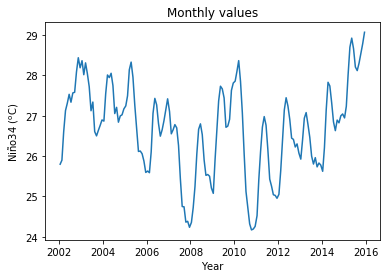

END


In [40]:
print('BEGIN.')

import math

rad = 4.0*math.atan(1.0)/180.0
#print('rad=',rad)

os.chdir(rundir)

grid_label='gr2'
grid_label='gn'
files_string='CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Omon/'+dvar+'/'+grid_label+'/v20171025/'+dvar+'_Omon_historical_CAFE-1-0_r1i1p2f1_'+grid_label+'_??????-??????.nc'
files=glob.glob(files_string)

print('input_files=',files)

ifh0=netCDF4.Dataset(files[1]) #choose if more than 1.

time=ifh0.variables['time']
lat=ifh0.variables['latitude'][:,0]
lon=ifh0.variables['longitude'][0,:]

#print('lat=',lat[122:152])
#print('lon=',lon[110:160])

clat=np.cos(lat[:]*rad)
#print('clat=',clat)
#break

nino34_monthly=np.average(np.average(ifh0.variables['tos'][:,122:152,110:160],axis=1,weights=clat[122:152]),axis=1) #need to add in area weighting strictly

'''
print('time.units=',time.units)
print('time.calendar=',time.calendar)
print('time=',time)
print('time[:]=',time[:])
'''

date_time_stamp=netCDF4.num2date(time[:],time.units,time.calendar)

#print('date_time_stamp=',date_time_stamp)

'''
print('date_time_stamp=',date_time_stamp)
num_stamp=netCDF4.date2num(date_time_stamp,time.units,time.calendar)
print('num_stamp=',num_stamp)
print('year_fraction=',year_fraction)
'''
year_fraction_monthly=fractional_year_from_num2date(date_time_stamp,time.calendar)

%matplotlib inline

plt.title('Monthly values')
plt.plot(year_fraction_monthly,nino34_monthly[:])
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()
print('END')

In the following monthly values will be calculated and then plotted.

BEGIN


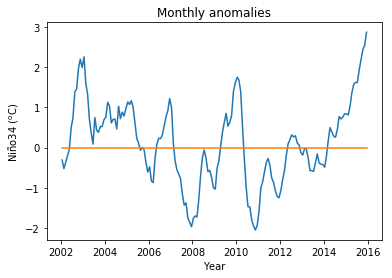

END


In [41]:
print('BEGIN')

ybeg=date_time_stamp[0].year
yend=date_time_stamp[-1].year

ydiff=yend-ybeg+1
nmy=12

MissingMonths=False

first_month=date_time_stamp[0].month
last_month=date_time_stamp[-1].month

missing_months_beg,missing_months_end=0,0

cyear_beg_skip,cyear_end_skip=0,1

if(first_month!=1):
  missing_months_beg=12-first_month
  cyear_beg_skip=1
  MissingMonths=True

if(last_month!=12):
  missing_months_end=12-last_month
  cyear_end_skip=2
  MissingMonths=True
  
if(MissingMonths):
  print('There are missing months in the set. '+str(missing_months_beg)+' at beginning and '+str(missing_months_end)+' at end.')
  print('Currently years with missing months are not used in generating long term monthly climatology.')
  print('And missing months will be set to missing in the final time-series.')
  ts_beg,ts_end,ts_avg,dt_beg,dt_end,dt_avg=get_timestamp_number(ybeg,yend,time.units,time.calendar)
  year_fraction_monthly_full=fractional_year_from_num2date(ts_avg,time.calendar)
  
  nino34_monthly_full= ma.masked_all(ydiff*nmy,dtype=float) #ensure missing months are masked out.
  last_month_index=ydiff*nmy-last_month
  nino34_monthly_full[first_month-1:last_month_index]=nino34_monthly
else:
  nino34_monthly_full=nino34_monthly
  year_fraction_monthly_full=year_fraction_monthly
  
nino34_monthly_reshaped=np.reshape(nino34_monthly_full,new_monthly_array_shape(nino34_monthly.shape,ydiff,nmy)) #check this works on large multi-dimensional arrays.

'''
#print('nino34_monthly_reshaped.shape=',nino34_monthly_reshaped.shape)
#print('cyear_beg,end_skip=',cyear_beg_skip,cyear_end_skip)
#print('ydiff=',ydiff)
#j=nino34_monthly_reshaped[cyear_beg_skip:-cyear_end_skip]
#print('j=',j)
'''

climatology=np.average(nino34_monthly_reshaped[cyear_beg_skip:-cyear_end_skip],axis=0) #average over full years only, this could be an option as could use for all years present.
nino34_monthly_climatology=np.expand_dims(climatology,0)
nino34_monthly_climatology=np.tile(nino34_monthly_climatology,(ydiff,1))
nino34_monthly_climatology_flat=nino34_monthly_climatology.flatten()
nino34_monthly_anomaly=nino34_monthly_full-nino34_monthly_climatology_flat

%matplotlib inline

zero=np.zeros(len(year_fraction_monthly_full))
plt.plot(year_fraction_monthly_full,nino34_monthly_anomaly)
plt.plot(year_fraction_monthly_full,zero)

plt.title('Monthly anomalies')
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()

#raise Exception('STOP!')
print('END')